In [1]:
#import all the packages you need
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#generate list for mock
PATH = os.getcwd()
print(PATH)
os.listdir(PATH)

G:\137_SUN2quant_redux\137_20190805_SUN2quant_repGrepH\_pipeline\v1_repCGH


['.ipynb_checkpoints',
 '137_20190805_SUN2quant_rerpCGH_v1_CNNexport_usingMODEL_137_20190805_SUN2quant_rerpCGH_v1.csv',
 '137_20190805_SUN2quant_rerpCGH_v1_CNNexport_usingMODEL_HCMV_generalizableCNN.csv',
 '137_20190805_SUN2quant_rerpCGH_v1_Cytoplasm.csv',
 '137_20190805_SUN2quant_rerpCGH_v1_Experiment.csv',
 '137_20190805_SUN2quant_rerpCGH_v1_IDsandCoords.csv',
 '137_20190805_SUN2quant_rerpCGH_v1_Image.csv',
 '137_20190805_SUN2quant_rerpCGH_v1_NUC_DAPI.csv',
 '137_20190805_SUN2quant_rerpCGH_v1_NUC_expanded.csv',
 'CNNpredictions_20190816_1220',
 'CNNpredictions_20190817_1145',
 'CNN_predictionsONLY.ipynb',
 'CNN_train&predict.ipynb',
 'fastai',
 'GenerateIDs&Coords.ipynb',
 'ID_NUC.cppipe',
 'ID_NUC.cpproj',
 'ID_NUC.txt',
 'LinescantoAnalysis.ipynb',
 'training_v1',
 'TrainngValidationSetSorter.ipynb']

### Create list of files in TB_perfect folders from our training, validation and v4 high confidnece (99%) CNN sorted dataset

In [3]:
exp_var = "137_20190805_SUN2quant_rerpCGH_v1"
date_var = 20190817
time_var = "1145"
#### make this a drop down box ####
MOCK_confidece_list = [99,90]
TB_confidence_list = [99,90]

MOCK_files = []
for conf in MOCK_confidece_list:
    MOCK_files_single_folder = os.listdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{conf}confidence\\MOCK')
    print(f'Loading {len(MOCK_files_single_folder)} files for MOCK {conf}confidence')
    MOCK_files = MOCK_files + MOCK_files_single_folder
print(f'Loaded {len(MOCK_files)} files total for TB')

TB_files = []
for conf in TB_confidence_list:
    TB_files_single_folder = os.listdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{conf}confidence\\TB_perfect')
    print(f'Loading {len(TB_files_single_folder)} files for TB {conf}confidence')
    TB_files = TB_files + TB_files_single_folder
print(f'Loaded {len(TB_files)} files total for TB')

#convert these lists to a dataframe
df_TB_ID = pd.DataFrame({'Unique_ID':TB_files})
df_MOCK_ID = pd.DataFrame({'Unique_ID':MOCK_files})

#strip "_RGB.jpg" from filename to match UNIQUE ID
df_TB_ID['Unique_ID'].replace(regex=True,inplace=True,to_replace='_RGB.jpg',value='')
df_MOCK_ID['Unique_ID'].replace(regex=True,inplace=True,to_replace='_RGB.jpg',value='')

#filter mock for only in mock sample (there are obviously some uninfected cells in the TB infected samples)
df_MOCK_ID = df_MOCK_ID[df_MOCK_ID['Unique_ID'].str.contains('MOCK')]
print(df_MOCK_ID.shape)
#filter TB for only in TB sample (just in case)
df_TB_ID = df_TB_ID[df_TB_ID['Unique_ID'].str.contains('_96hpi_')]
print(df_TB_ID.shape)

# IMPORT DATAFRAME WHERE WE CREATED THE IDs and COORDS FOR THIS DATASET
df_coords = pd.read_csv(f'{exp_var}_IDsandCoords.csv')
#df_FULL = pd.read_csv("117_20181023_SUN2_v4_IDsandCoords_FULL.csv") #create a FULL version of the dataframe in the Generate IDs and coords notebook

# Merge coords with lists from CNN sorting for TB
df_TB_CNNsorted99_coords = df_coords.merge(df_TB_ID, left_on='Unique_ID', right_on='Unique_ID', how='right')
df_MOCK_CNNsorted99_coords = df_coords.merge(df_MOCK_ID, left_on='Unique_ID', right_on='Unique_ID', how='right')
#df_TB_CNNsorted99_FULL = df_FULL.merge(df_TB_ID, left_on='Unique_ID', right_on='Unique_ID', how='right')
#df_MOCK_CNNsorted99_FULL = df_FULL.merge(df_MOCK_ID, left_on='Unique_ID', right_on='Unique_ID', how='right')

Loading 30235 files for MOCK 99confidence
Loading 4782 files for MOCK 90confidence
Loaded 35017 files total for TB
Loading 3396 files for TB 99confidence
Loading 654 files for TB 90confidence
Loaded 4050 files total for TB
(28113, 1)
(4050, 1)


In [4]:
#now we need to generate the x1,y1 and x2,y2 coords for the MOCK nuclei
#set the length of the linescan to be performed
linescan_len = 1000 # lenght in pixels
radius_len = linescan_len/2

df_merge_OUTPUT = df_MOCK_CNNsorted99_coords

#get the orientation of the minor axis in radians
df_merge_OUTPUT['NUC_orientation_radians'] = (df_merge_OUTPUT[('AreaShape_Orientation')]+90).apply(np.radians)

#calculate the coordinates of points (x1,y1), (x2,y2) drawing a 300 pixel line along the minor axis and passing through the center of the nucleus 
df_merge_OUTPUT['NUC_x1'] = df_merge_OUTPUT['NUC_x0'] + df_merge_OUTPUT['NUC_orientation_radians'].apply(np.cos).multiply(radius_len)
df_merge_OUTPUT['NUC_y1'] = df_merge_OUTPUT['NUC_y0'] + df_merge_OUTPUT['NUC_orientation_radians'].apply(np.sin).multiply(radius_len)
df_merge_OUTPUT['NUC_x2'] = df_merge_OUTPUT['NUC_x0'] - df_merge_OUTPUT['NUC_orientation_radians'].apply(np.cos).multiply(radius_len)
df_merge_OUTPUT['NUC_y2'] = df_merge_OUTPUT['NUC_y0'] - df_merge_OUTPUT['NUC_orientation_radians'].apply(np.sin).multiply(radius_len)

df_MOCK_CNNsorted99_coords = df_merge_OUTPUT

In [5]:
df_MOCK_CNNsorted99_coords.head()

,Unique_ID,NUC_x0,NUC_y0,URL_C1,URL_C2,URL_C3,AreaShape_Orientation,CYTO_x0,CYTO_y0,NUC_orientation_radians,NUC_x1,NUC_y1,NUC_x2,NUC_y2
0,137_20190724_repC_MOCK_2551_1,1049.923913,126.858696,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,29.782666,1039.730936,173.319988,2.090602,801.568206,560.816577,1298.279620,-307.099186
1,137_20190724_repC_MOCK_2551_2,1454.035990,216.781491,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,43.635216,1484.480272,247.048593,2.332375,1109.003732,578.655421,1799.068247,-145.092439
2,137_20190724_repC_MOCK_2551_3,850.065997,670.944046,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,29.210842,855.116274,667.528347,2.080622,606.053577,1107.358916,1094.078417,234.529176
3,137_20190724_repC_MOCK_2551_5,1895.348018,1148.334802,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,88.337802,1865.499685,1157.526984,3.112582,1395.558410,1162.838177,2395.137625,1133.831426
4,137_20190724_repC_MOCK_2551_6,190.601824,1398.285714,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,47.331661,201.148659,1397.566649,2.396890,-177.042792,1737.162442,558.246440,1059.408987


In [6]:
#Now because imageJ needs these broken up into individual smaller CSV files to run efficiently
split_number =25
base_filename_for_csvs = f'{exp_var}_MOCK_99conf_sorted_IDandCOORDS_overfolder'
os.mkdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_csvfolderMOCK')
os.mkdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_profileMOCK')
for g, df in df_MOCK_CNNsorted99_coords.groupby(np.arange(len(df_MOCK_CNNsorted99_coords)) // split_number):
    #print(df.shape)  #can get rid of this line
    df.name = g #can get rid of this line
    #print(df.name) #can get rid of this line
    name = f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_csvfolderMOCK\\{base_filename_for_csvs}_{str(g)}.csv'
    df.to_csv(name, index=False)   

In [16]:
import pandas as pd
import glob

path = f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_profileMOCK' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, na_values=0, index_col=None, header=0)
    df.drop(df.columns[0], axis=1, inplace=True)
    li.append(df)

concat_df_MOCK = pd.concat(li, axis=1)

In [17]:
print(concat_df_MOCK.shape)
concat_df_MOCK.head()

(1001, 84339)


,137_20190724_repC_MOCK_2551_1_C1,137_20190724_repC_MOCK_2551_1_C2,137_20190724_repC_MOCK_2551_1_C3,137_20190724_repC_MOCK_2551_2_C1,137_20190724_repC_MOCK_2551_2_C2,137_20190724_repC_MOCK_2551_2_C3,137_20190724_repC_MOCK_2551_3_C1,137_20190724_repC_MOCK_2551_3_C2,137_20190724_repC_MOCK_2551_3_C3,137_20190724_repC_MOCK_2551_5_C1,...,137_20190809_repH_MOCK_14322_7_C3,137_20190809_repH_MOCK_14322_8_C1,137_20190809_repH_MOCK_14322_8_C2,137_20190809_repH_MOCK_14322_8_C3,137_20190809_repH_MOCK_14323_1_C1,137_20190809_repH_MOCK_14323_1_C2,137_20190809_repH_MOCK_14323_1_C3,137_20190809_repH_MOCK_14323_2_C1,137_20190809_repH_MOCK_14323_2_C2,137_20190809_repH_MOCK_14323_2_C3
0,379.890508,1316.102082,2659.940224,394.793666,424.475748,331.731872,497.311718,647.616696,298.572507,437.203414,...,66.584645,176.430967,175.595212,158.089709,265.448610,1395.822653,1504.966315,234.619622,262.924596,240.217500
1,379.200731,1295.578772,2630.897223,394.919306,428.057786,329.521647,493.421391,648.371322,301.294466,427.776614,...,79.999329,178.238273,178.189255,159.741522,265.990261,1401.899597,1490.318161,233.341686,260.958164,238.543151
2,376.066979,1274.794448,2590.939471,393.204967,433.212992,324.626698,494.947135,653.450947,305.053958,420.494276,...,94.914099,178.741362,178.743697,160.895161,267.618319,1405.149240,1480.019485,237.308719,263.463089,240.411784
3,380.829874,1270.772560,2574.343324,396.766096,437.155870,318.469650,495.627948,652.548225,306.552023,412.006753,...,109.853844,179.768979,178.115832,161.235587,271.269773,1404.448698,1468.143901,240.955552,266.230497,242.168814
4,379.665268,1253.792766,2547.439491,397.915006,437.473225,315.579246,492.972465,652.061496,308.875523,410.375349,...,123.501020,179.375715,177.058491,161.121127,274.251540,1406.306220,1464.204324,243.788639,267.357306,246.262092


In [19]:
biorep_li = ["repC","repG","repH"]

for biorep_val in biorep_li:
    print(f'{biorep_val} contrains {concat_df_MOCK.filter(like=biorep_val, axis=1).shape[1]/3:.0f} nuclei') 
    concat_df_MOCK.filter(like=biorep_val, axis=1).to_csv(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{exp_var}_RawLinescans_MOCK_{biorep_val}_only.csv', index=False)   

repC contrains 11551 nuclei
repG contrains 10622 nuclei
repH contrains 5940 nuclei


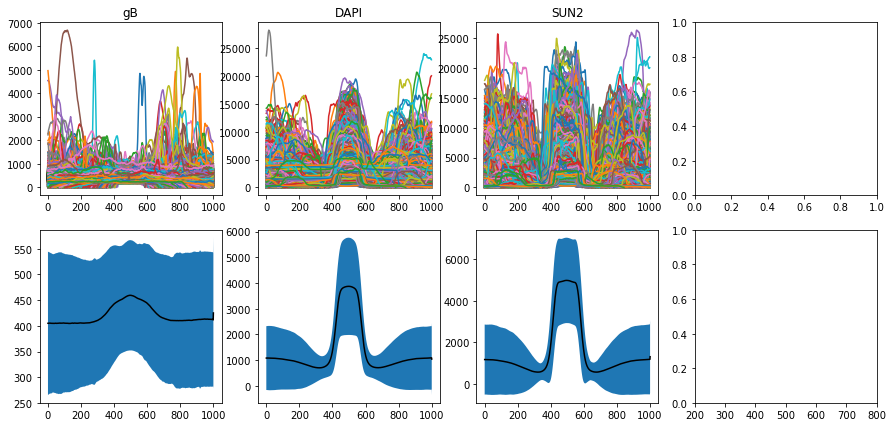

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

df_linescan_MOCK_500 = concat_df_MOCK

df_linescan_MOCK_500_C1 = df_linescan_MOCK_500.filter(regex='C1')
df_linescan_MOCK_500_C2 = df_linescan_MOCK_500.filter(regex='C2')
df_linescan_MOCK_500_C3 = df_linescan_MOCK_500.filter(regex='C3')


titles = ['gB', 'DAPI', 'SUN2']

figure, ax = plt.subplots(ncols=4, nrows=2, figsize=(15,7)) #sharex=True, sharey=True)

ax[0,0].set(title=titles[0])
ax[0,0].plot(df_linescan_MOCK_500_C1) 
ax[1,0].plot(df_linescan_MOCK_500_C1.mean(axis=1),'k-')

MOCK_C1_error_high = df_linescan_MOCK_500_C1.mean(axis=1) + df_linescan_MOCK_500_C1.std(axis=1)
MOCK_C1_error_low = df_linescan_MOCK_500_C1.mean(axis=1) - df_linescan_MOCK_500_C1.std(axis=1)
N=list(df_linescan_MOCK_500_C1.index)
ax[1,0].fill_between(N,MOCK_C1_error_high,MOCK_C1_error_low)

ax[0,1].set(title=titles[1])
ax[0,1].plot(df_linescan_MOCK_500_C2) 
ax[1,1].plot(df_linescan_MOCK_500_C2.mean(axis=1),'k-')
MOCK_C2_error_high = df_linescan_MOCK_500_C2.mean(axis=1) + df_linescan_MOCK_500_C2.std(axis=1)
MOCK_C2_error_low = df_linescan_MOCK_500_C2.mean(axis=1) - df_linescan_MOCK_500_C2.std(axis=1)
N=list(df_linescan_MOCK_500_C2.index)
ax[1,1].fill_between(N,MOCK_C2_error_high,MOCK_C2_error_low)


ax[0,2].set(title=titles[2])
ax[0,2].plot(df_linescan_MOCK_500_C3) 
ax[1,2].plot(df_linescan_MOCK_500_C3.mean(axis=1),'k-')
MOCK_C3_error_high = df_linescan_MOCK_500_C3.mean(axis=1) + df_linescan_MOCK_500_C3.std(axis=1)
MOCK_C3_error_low = df_linescan_MOCK_500_C3.mean(axis=1) - df_linescan_MOCK_500_C3.std(axis=1)
N=list(df_linescan_MOCK_500_C3.index)
ax[1,2].fill_between(N,MOCK_C3_error_high,MOCK_C3_error_low)
ax[1,3].set_xlim(200,800)
plt.show()

### NOW PERFORM ON TB

In [7]:
df_merge_OUTPUT = df_TB_CNNsorted99_coords

In [8]:
#get the center of the AC (AC_x0)(we will filter out for uninfected cells later)
df_merge_OUTPUT['AC_x0'] = df_merge_OUTPUT['CYTO_x0']
df_merge_OUTPUT['AC_y0'] = df_merge_OUTPUT['CYTO_y0']

#calculate the AC to NUC orientation in radians 
df_TB_CNNsorted99_coords["AC_to_NUC_orientation_radians"] =  np.arctan2((df_merge_OUTPUT['AC_y0'] - df_merge_OUTPUT['NUC_y0']),(df_merge_OUTPUT['AC_x0'] - df_merge_OUTPUT['NUC_x0']))

In [9]:
df_merge_OUTPUT.loc[df_merge_OUTPUT["AC_to_NUC_orientation_radians"]<0, ["AC_to_NUC_orientation_radians"]] = 2*np.pi+ df_merge_OUTPUT["AC_to_NUC_orientation_radians"]

In [10]:
#df_merge_OUTPUT["AC_to_NUC_orientation_radians"]

In [11]:
#NOTE THIS MAY SCREW UP FOR THE NEW WAY WE ARE SEGMENTING THE AC. YOU MAY HAVE TO RERUN FOR THE THINGS YOU KNOW YOU WANT TO PROCESS WITH LINESCANS
df_merge_OUTPUT["ACtoNUC_X_Midpoint"] = (df_merge_OUTPUT['NUC_x0'] + df_merge_OUTPUT['AC_x0'])/2
df_merge_OUTPUT["ACtoNUC_Y_Midpoint"] = (df_merge_OUTPUT['NUC_y0'] + df_merge_OUTPUT['AC_y0'])/2

radius_val = 1000

df_merge_OUTPUT["X_AC_fixedradius"] = df_merge_OUTPUT["ACtoNUC_X_Midpoint"] + radius_val *  np.cos(df_merge_OUTPUT['AC_to_NUC_orientation_radians'] - np.pi)
df_merge_OUTPUT["Y_AC_fixedradius"] = df_merge_OUTPUT["ACtoNUC_Y_Midpoint"] + radius_val *  np.sin(df_merge_OUTPUT['AC_to_NUC_orientation_radians'] - np.pi)

df_merge_OUTPUT["X_NUC_fixedradius"] = df_merge_OUTPUT["ACtoNUC_X_Midpoint"] + radius_val * np.cos(df_merge_OUTPUT['AC_to_NUC_orientation_radians'])
df_merge_OUTPUT["Y_NUC_fixedradius"] = df_merge_OUTPUT["ACtoNUC_Y_Midpoint"] + radius_val * np.sin(df_merge_OUTPUT['AC_to_NUC_orientation_radians'])
df_merge_OUTPUT["AC_to_NUC_orientation_degrees"] = df_merge_OUTPUT['AC_to_NUC_orientation_radians'].apply(np.degrees)

In [12]:
df_merge_OUTPUT.head()

,Unique_ID,NUC_x0,NUC_y0,URL_C1,URL_C2,URL_C3,AreaShape_Orientation,CYTO_x0,CYTO_y0,AC_x0,AC_y0,AC_to_NUC_orientation_radians,ACtoNUC_X_Midpoint,ACtoNUC_Y_Midpoint,X_AC_fixedradius,Y_AC_fixedradius,X_NUC_fixedradius,Y_NUC_fixedradius,AC_to_NUC_orientation_degrees
0,137_20190724_repC_96hpi_1_2,1634.770149,257.438806,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,-68.582987,1627.798067,231.399136,1627.798067,231.399136,4.450777,1631.284108,244.418971,1889.922260,1210.393249,1372.645956,-721.555307,255.010730
1,137_20190724_repC_96hpi_2_5,993.882353,1512.561304,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,-23.523878,1024.930107,1579.024636,1024.930107,1579.024636,1.133780,1009.406230,1545.792970,586.167823,639.774620,1432.644636,2451.811320,64.960789
2,137_20190724_repC_96hpi_3_1,224.478832,286.785401,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,74.486222,275.223438,293.954644,275.223438,293.954644,0.140352,249.851135,290.370022,-740.315685,150.478394,1240.017956,430.261651,8.041575
3,137_20190724_repC_96hpi_3_3,239.886202,1217.297297,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,32.955051,255.908098,1287.759980,255.908098,1287.759980,1.347216,247.897150,1252.528639,26.175387,277.418665,469.618913,2227.638612,77.189819
4,137_20190724_repC_96hpi_5_2,690.549451,435.355311,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,file:///G:/137_SUN2quant_redux/137_20190724_SU...,34.152841,679.298789,484.081058,679.298789,484.081058,1.797717,684.924120,459.718185,909.902453,-514.645582,459.945787,1434.081951,103.001604


In [13]:
df_TB_CNNsorted99_coords_NUCtoAC = df_merge_OUTPUT
df_TB_CNNsorted99_coords_NUCtoAC.shape

(4050, 19)

In [14]:
### now do this over folders

In [15]:
#Now because imageJ needs these broken up into individual smaller CSV files to run efficiently
split_number =25
base_filename_for_csvs = f'{exp_var}_TB_99conf_sorted_IDandCOORDS_overfolder'
os.mkdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_csvfolderTB')
os.mkdir(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_profilesTB')
for g, df in df_TB_CNNsorted99_coords_NUCtoAC.groupby(np.arange(len(df_TB_CNNsorted99_coords_NUCtoAC)) // split_number):
    #print(df.shape)  #can get rid of this line
    df.name = g #can get rid of this line
    #print(df.name) #can get rid of this line
    name = f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_csvfolderTB\\{base_filename_for_csvs}_{str(g)}.csv'
    df.to_csv(name, index=False)   

In [21]:
import pandas as pd
import glob

path = f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\_profilesTB' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, na_values=0, index_col=None, header=0)
    df.drop(df.columns[0], axis=1, inplace=True)
    li.append(df)

concat_df_TB = pd.concat(li, axis=1)

In [22]:
concat_df_TB.shape

(2001, 12150)

In [23]:
concat_df_TB.head()

,137_20190724_repC_96hpi_1_2_C1,137_20190724_repC_96hpi_1_2_C2,137_20190724_repC_96hpi_1_2_C3,137_20190724_repC_96hpi_2_5_C1,137_20190724_repC_96hpi_2_5_C2,137_20190724_repC_96hpi_2_5_C3,137_20190724_repC_96hpi_3_1_C1,137_20190724_repC_96hpi_3_1_C2,137_20190724_repC_96hpi_3_1_C3,137_20190724_repC_96hpi_3_3_C1,...,137_20190724_repC_96hpi_2394_5_C3,137_20190724_repC_96hpi_2395_2_C1,137_20190724_repC_96hpi_2395_2_C2,137_20190724_repC_96hpi_2395_2_C3,137_20190724_repC_96hpi_2395_3_C1,137_20190724_repC_96hpi_2395_3_C2,137_20190724_repC_96hpi_2395_3_C3,137_20190724_repC_96hpi_2396_1_C1,137_20190724_repC_96hpi_2396_1_C2,137_20190724_repC_96hpi_2396_1_C3
0,532.304630,606.394806,277.578145,658.313628,604.922297,753.145855,NaN,NaN,NaN,577.196413,...,NaN,NaN,NaN,NaN,734.303745,589.620380,936.875882,NaN,NaN,NaN
1,529.692510,603.479032,282.189306,652.734573,599.423077,764.845057,NaN,NaN,NaN,580.761217,...,NaN,NaN,NaN,NaN,732.343728,589.160114,929.182475,NaN,NaN,NaN
2,535.315813,607.550741,281.664324,648.909019,599.833737,775.994534,NaN,NaN,NaN,590.082498,...,NaN,NaN,NaN,NaN,730.975730,591.808065,929.377602,NaN,NaN,NaN
3,540.402067,606.480624,279.956824,639.669759,599.625385,789.889050,NaN,NaN,NaN,596.160734,...,NaN,NaN,NaN,NaN,729.099537,597.483762,930.538764,NaN,NaN,NaN
4,542.260481,603.136159,279.353120,632.714766,600.454848,796.366178,NaN,NaN,NaN,599.437436,...,NaN,NaN,NaN,NaN,729.096348,598.571874,934.570359,NaN,NaN,NaN


In [24]:
biorep_li = ["repC","repG","repH"]

for biorep_val in biorep_li:
    print(f'{biorep_val} contrains {concat_df_TB.filter(like=biorep_val, axis=1).shape[1]/3:.0f} nuclei') 
    concat_df_TB.filter(like=biorep_val, axis=1).to_csv(f'{PATH}\\CNNpredictions_{date_var}_{time_var}\\{exp_var}_RawLinescans_TB_{biorep_val}_only.csv', index=False)   

repC contrains 2666 nuclei
repG contrains 560 nuclei
repH contrains 824 nuclei


In [25]:
#these are the results for the random Mock 500 sample
df_linescan_TB= concat_df_TB

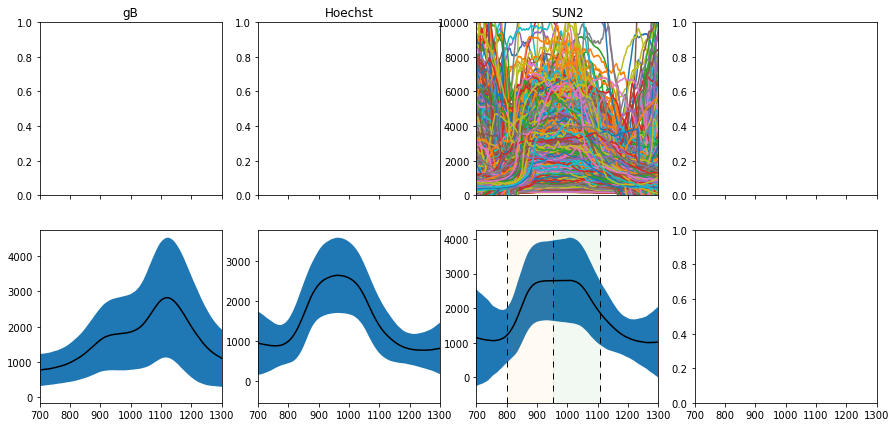

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

df_linescan_TB_C1 = df_linescan_TB.filter(regex='C1')
df_linescan_TB_C2 = df_linescan_TB.filter(regex='C2')
df_linescan_TB_C3 = df_linescan_TB.filter(regex='C3')

figure, ax = plt.subplots(ncols=4, nrows=2, figsize=(15,7), sharex=True) #, sharey=True)

ax[0,0].set(title="gB")
#ax[0,0].plot(df_linescan_TB_C1) 
ax[1,0].plot(df_linescan_TB_C1.mean(axis=1),'k-')

TB_C1_error_high = df_linescan_TB_C1.mean(axis=1) + df_linescan_TB_C1.std(axis=1)
TB_C1_error_low = df_linescan_TB_C1.mean(axis=1) - df_linescan_TB_C1.std(axis=1)
N=list(df_linescan_TB_C1.index)
ax[1,0].fill_between(N,TB_C1_error_high,TB_C1_error_low)

ax[0,1].set(title="Hoechst")
#ax[0,1].plot(df_linescan_TB_C2) 
ax[1,1].plot(df_linescan_TB_C2.mean(axis=1),'k-')
TB_C2_error_high = df_linescan_TB_C2.mean(axis=1) + df_linescan_TB_C2.std(axis=1)
TB_C2_error_low = df_linescan_TB_C2.mean(axis=1) - df_linescan_TB_C2.std(axis=1)
N=list(df_linescan_TB_C2.index)
ax[1,1].fill_between(N,TB_C2_error_high,TB_C2_error_low)

ax[0,2].set(title="SUN2")
ax[0,2].plot(df_linescan_TB_C3) 
ax[1,2].plot(df_linescan_TB_C3.mean(axis=1),'k-')
ax[0,2].set_ylim(0,10000)
TB_C3_error_high = df_linescan_TB_C3.mean(axis=1) + df_linescan_TB_C3.std(axis=1)
TB_C3_error_low = df_linescan_TB_C3.mean(axis=1) - df_linescan_TB_C3.std(axis=1)
N=list(df_linescan_TB_C3.index)
ax[1,2].fill_between(N,TB_C3_error_high,TB_C3_error_low)
ax[1,2].set_xlim(700,1300)
#ax[1,2].set_ylim(0,3000)

midpoint = 954
span = (400/26)*10

ax[1,2].axvline(x=midpoint, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvline(x=midpoint-span, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvline(x=midpoint+span, dashes=[6,6], linewidth=1,color='k')
ax[1,2].axvspan((midpoint-span), midpoint, alpha=0.05, color='orange')
ax[1,2].axvspan(midpoint,(midpoint+span), alpha=0.05, color='green')

plt.show()

In [28]:
def merge_MOCK_TB(df_MOCK, df_TB):
    df_FINAL = pd.concat([df_MOCK, df_TB], axis=1)
    print(df_MOCK.shape)
    print(df_TB.shape)
    print(df_FINAL.shape)
    return df_FINAL

In [29]:
df_FINAL = merge_MOCK_TB(concat_df_MOCK,concat_df_TB)

(1001, 84339)
(2001, 12150)
(2001, 96489)


In [30]:
def getMEAN_SEM_UPPER_LOWER(df):
    df_T = df.T
    df_T["biorep"] = df_T.index.str.split('_').str[2]
    df_T["timepoint"] = df_T.index.str.split('_').str[3]
    df_T["channel"] = df_T.index.str.split('_').str[6]
    df_T.set_index(["biorep", "timepoint","channel"], inplace=True)
    df_tec_mean = df_T.groupby(["biorep","channel", "timepoint"]).mean()
    df_bio_mean = df_tec_mean.groupby(["channel", "timepoint"]).mean()
    df_bio_sem = df_tec_mean.groupby(["channel", "timepoint"]).std()/np.sqrt(3)
    df_upper = df_bio_mean + df_bio_sem
    df_lower = df_bio_mean - df_bio_sem
    return df_bio_mean, df_upper, df_lower

In [31]:
df_bio_mean, df_upper, df_lower = getMEAN_SEM_UPPER_LOWER(df_FINAL)
df_bio_mean.head()

0            1            2            3     \
channel timepoint                                                       
C1      96hpi       600.237229   600.427820   601.302292   600.486591   
        MOCK        393.805563   393.711476   393.831472   393.895991   
C2      96hpi      1210.972453  1210.950446  1212.540869  1210.539703   
        MOCK       1142.009874  1141.650086  1142.231560  1142.375955   
C3      96hpi      1114.535605  1113.798306  1114.493323  1112.599659   

                          4            5            6            7     \
channel timepoint                                                       
C1      96hpi       601.229736   601.932431   601.702563   602.089095   
        MOCK        393.941908   393.950816   394.025679   394.061698   
C2      96hpi      1211.767792  1213.467267  1213.514518  1214.759488   
        MOCK       1142.460450  1142.533168  1142.754334  1142.964578   
C3      96hpi      1113.442071  1114.883545  1115.006979  1115.795513   

                          8            9     ...         1991         1992  \
channel timepoint                            ...                             
C1      96hpi       601.542832   601.783778  ...   607.270942   606.794227   
        MOCK        394.136656   394.209527  ...          NaN          NaN   
C2      96hpi      1214.278463  1215.304523  ...  1150.577492  1149.176629   
        MOCK       1143.142427  1143.449169  ...          NaN          NaN   
C3      96hpi      1115.346199  1115.681267  ...  1077.788047  1076.601602   

                          1993         1994         1995         1996  \
channel timepoint                                                       
C1      96hpi       606.884714   607.313645   607.055379   608.165533   
        MOCK               NaN          NaN          NaN          NaN   
C2      96hpi      1150.152814  1151.542766  1151.130008  1154.099567   
        MOCK               NaN          NaN          NaN          NaN   
C3      96hpi      1077.048250  1078.157950  1078.465541  1081.282322   

                          1997         1998         1999         2000  
channel timepoint                                                      
C1      96hpi       607.546190   606.317677   601.620757   519.197727  
        MOCK               NaN          NaN          NaN          NaN  
C2      96hpi      1152.709864  1151.437436  1167.204596  1756.316956  
        MOCK               NaN          NaN          NaN          NaN  
C3      96hpi      1080.851008  1077.228244  1104.367860   521.164092  

[5 rows x 2001 columns]

In [32]:
def multi_chan(df_bio_mean,df_upper,df_lower):

    for channel_ID, channel_name in channel_dict.items():
        f = plt.figure()   
        ax = f.add_subplot(111)
        ax.plot(df_bio_mean.loc[(channel_ID,"96hpi")],'k-',label='_nolegend_')
        N=list(df_bio_mean.loc[(channel_ID,"96hpi")].index)
        ax.fill_between(N,df_upper.loc[(channel_ID,"96hpi")],df_lower.loc[(channel_ID,"96hpi")],label=f"TB-{channel_name}", alpha=0.5)
        ax.plot(df_bio_mean.loc[(channel_ID,"MOCK")],'k-',label='_nolegend_')
        N=list(df_bio_mean.loc[(channel_ID,"MOCK")].index)
        ax.fill_between(N,df_upper.loc[(channel_ID,"MOCK")],df_lower.loc[(channel_ID,"MOCK")],label=f"MOCK-{channel_name}", alpha=0.5)
        plt.legend()
        plt.show()

In [33]:
#multi_chan(df_bio_mean,df_upper,df_lower)

In [37]:
from matplotlib.ticker import FuncFormatter

def multi_chan_shifted(df_bio_mean,df_upper,df_lower,shift_val):
    MOCK_x_values = np.linspace(shift_val, (shift_val+2001), 2001)
    print(MOCK_x_values)
    for channel_ID, channel_name in channel_dict.items():
        f = plt.figure()   
        ax = f.add_subplot(111)
        
        increment = 1
        ticks_at = 5
        start_val = 12
        shift_axis = 62
        end_Val = start_val + shift_axis + 20
        
        
        ax.set_xlim( ((400/26)*increment)*start_val,((400/26)*increment)*(end_Val-1))
        ax.xaxis.set_ticks(np.arange(((400/26)*increment)*start_val, ((400/26)*increment)*end_Val, (400/26)*ticks_at))
        plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,y: '{}'.format(round((x*65)/1000,1)-shift_axis) ))
        ax.set_xlim(750,1250)
       
        #plot TB
        ax.plot(df_bio_mean.loc[(channel_ID,"96hpi")],'k-',label='_nolegend_')
        N=list(df_bio_mean.loc[(channel_ID,"96hpi")].index)
        ax.fill_between(N,df_upper.loc[(channel_ID,"96hpi")],df_lower.loc[(channel_ID,"96hpi")],label=f"{channel_name}-TB", alpha=0.5)
        
        #plot MOCK
        ax.plot(MOCK_x_values,df_bio_mean.loc[(channel_ID,"MOCK")],'k-',label='_nolegend_')
        N=list(df_bio_mean.loc[(channel_ID,"MOCK")].index)
        ax.fill_between(MOCK_x_values,df_upper.loc[(channel_ID,"MOCK")],df_lower.loc[(channel_ID,"MOCK")],label=f"{channel_name}-MOCK", alpha=0.5)
        
        ax.yaxis.tick_right()
        plt.legend()
        plt.savefig(f'{exp_var}_GRAP_{channel_name}.png', dpi=600)
        plt.show()
        

[ 465.      466.0005  467.001  ... 2463.999  2464.9995 2466.    ]


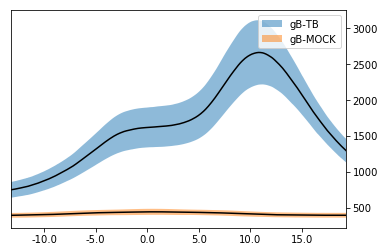

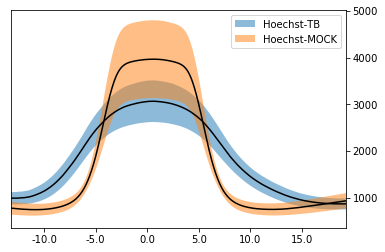

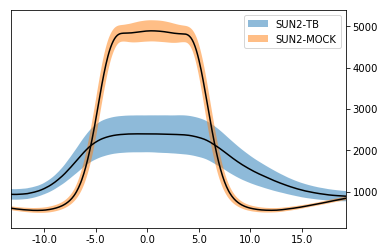

In [38]:
channel_dict = {
    "C1":"gB",
    "C2":"Hoechst",
    "C3":"SUN2"}

multi_chan_shifted(df_bio_mean,df_upper,df_lower,465)